In [1]:
import metpy.calc as mpcalc
from metpy.constants import g, Cp_d, Lv, Rd
from datetime import datetime
from siphon.simplewebservice.wyoming import WyomingUpperAir
from metpy.units import units, concatenate
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# These functions are PR's for MetPy already

def dry_static_energy(heights, temperature):
    r"""Calculate the dry static energy of parcels.

    This function will calculate the dry static energy following the first two terms of
    equation 3.72 in [REF.

    Notes
    -----
    .. math::\text{dry static energy} = c_{pd} * T + gz

    * :math:`T` is temperature
    * :math:`z` is height

    Parameters
    ----------
    heights : array-like
        Atmospheric height profile
    temperature : array-like
        Atmospheric temperature profile

    Returns
    -------
    `pint.Quantity`
        The dry static energy.

    """

    return g * heights + Cp_d * temperature


def moist_static_energy(heights, temperature, specific_humidity):
    r"""Calculate the moist static energy of parcels.

    This function will calculate the moist static energy following equation 3.72 in [REF.

    Notes
    -----
    .. math::\text{moist static energy} = c_{pd} * T + gz + L_v q

    * :math:`T` is temperature
    * :math:`z` is height
    * :math:`q` is specific humidity

    Parameters
    ----------
    heights : array-like
        Atmospheric height profile
    temperature : array-like
        Atmospheric temperature profile
    specific_humidity : array-like
        Atmospheric specific humidity profile

    Returns
    -------
    `pint.Quantity`
        The moist static energy.

    """

    return dry_static_energy(heights, temperature) + Lv * specific_humidity


def specific_humidity_from_mixing_ratio(mixing_ratio):
    r"""Calculate the specific humidity from the mixing ratio.

    Parameters
    ----------
    mixing_ratio: `pint.Quantity`
        mixing ratio

    Returns
    -------
    `pint.Quantity`
        Specific humidity

    Notes
    -----
    Formula from [Salby1996]_ pg. 118.

    .. math:: q = \frac{w}{1+w}

    * :math:`w` is mixing ratio
    * :math:`q` is the specific humidity

    See Also
    --------
    mixing_ratio

    """
    return mixing_ratio / (1 + mixing_ratio)

In [7]:
date = datetime(2002, 11, 11, 0)
station = 'BNA'

df = WyomingUpperAir.request_data(date, station)
pressure = df['pressure'].values * units(df.units['pressure'])
temperature = df['temperature'].values * units(df.units['temperature'])
dewpoint = df['dewpoint'].values * units(df.units['dewpoint'])
heights = df['height'].values * units(df.units['height'])

# Calculate mixing ratios
q = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(dewpoint), pressure)
qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(temperature), pressure)

# Calculate variables to plot
s = dry_static_energy(heights, temperature).to('kJ/kg')
sv = dry_static_energy(heights, mpcalc.virtual_temperature(temperature, q)).to('kJ/kg')
h = moist_static_energy(heights, temperature, q).to('kJ/kg')
hs = moist_static_energy(heights, temperature, qs).to('kJ/kg')

In [8]:
class massEnergyPlot(object):
    
    def __init__(self, fig=None, ax=None):
        # Setup figure and axes if we don't have them
        if fig is None:
            fig = plt.figure(figsize=(11,8))
        if ax is None:
            ax = plt.subplot(1, 1, 1)
        self.fig = fig
        self.ax = ax
        
        # Set default axis limits
        self.ax.set_xlim(250, 400)
        self.ax.set_ylim(1050, 100)

    def isohumes(self, values=np.arange(10, 100, 10) * units.percent, label=True, label_position=800 * units.hPa):
        # TODO: 
        # - Take user kwargs for plot line style and label style
        
        # Add lines of constant RH
        idx = np.argmin(np.abs(pressure - label_position))
        for rh in np.arange(10, 100, 10) * units.percent:
            self.ax.plot( s + Lv * qs * rh, pressure, linewidth=0.5, linestyle=':', color='black')
            # Add labels for the RH values
            if label:
                self.ax.annotate(rh.m, xy=( (s[idx]+Lv*qs[idx]*rh).to('kJ/kg'), label_position),                    
                        horizontalalignment='center',fontsize=8)
                
    def shade_precipitable_water(self, pressure, moist_static_energy, dry_static_energy):
        self.ax.fill_betweenx(pressure, moist_static_energy, dry_static_energy, where=dry_static_energy>moist_static_energy, facecolor='tab:blue', alpha=0.4)

    def rce_reference(self, xloc=260 * units('kJ/kg'), yloc=1045 * units.hPa):
        """Reference line for radiative convective equilibrium."""
        self.ax.plot(np.ones((2)) * xloc, [0, 1100]*units.hPa, linewidth=0.5)
        self.ax.annotate('Daily RCE', xy=(xloc, yloc), horizontalalignment='center')
    
    def radiative_cooling_reference(self, xloc=260 * units('kJ/kg')):
        RCEloc = 260 * units('kJ/kg')
        x_points = concatenate([xloc, xloc - (1.3 * units('kJ/kg')), xloc - (1.3 * units('kJ/kg')), xloc, xloc ])
        y_points = concatenate([1000 , 1000    , 200     , 200, 1000]) * units.hPa
        self.ax.fill(x_points, y_points, linewidth=1, color='c', alpha=0.9)

        self.ax.annotate('Cooling $-1.3 K/d$',  xy=(RCEloc, 300), color='c')
        self.ax.annotate('$-10^7 J m^{-2}$', xy=(RCEloc, 330))
    
    def surface_flux_reference(self, xloc=260 * units('kJ/kg')):
        self.ax.fill(concatenate([xloc, xloc + 11 * units('kJ/kg'), xloc + 11 * units('kJ/kg'), xloc, xloc]),             
                concatenate([1000 , 1000   , 910    , 910, 1000] * units.hPa),             
                linewidth=1, color='orange', alpha=0.5)

        self.ax.annotate(' heat flux', xy=(xloc,890 * units.hPa), color='orange')
        self.ax.annotate('116 $W m^{-2}$', xy=(xloc,940 * units.hPa))
        self.ax.annotate(' for 1 day'     , xy=(xloc,960 * units.hPa), fontsize=9)
        self.ax.annotate('=$10^7 J m^{-2}$'  , xy=(xloc, 990 * units.hPa))
    
    def internal_waves(self, pressure, amplitude=100*units.m, levels=np.arange(900, 100, -100) * units.hPa):
        # TODO:
        # - line plotting parameters

        for level in levels:
            print(level)
            idx = np.argmin(np.abs(pressure - level))
            
            # Wave temperature change
            wave_dT = -g / Cp_d * amplitude
            displaced_temperature = temperature[idx] + wave_dT.to('delta_degC')
    
            # Wave pressure change
            density = pressure[idx] / Rd / temperature[idx]
            wave_dp = -density * g * amplitude
            
            # dhsat
            dqs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(displaced_temperature), 
                                      pressure[idx] + wave_dp) - qs[idx]
            dhs = g * amplitude + Cp_d * wave_dT + Lv * dqs
            
            # Plot internal waves
            colors = ['tab:red', 'tab:red', 'tab:blue']
            #for var, color in zip([hs + dhs, s, h], colors):
            self.ax.plot( (hs[idx] + dhs * concatenate([-1,1] * hs.units)), p[idx] + dp * concatenate([-1,1] * units.hPa), linewidth=3, color='r')  
            self.ax.plot( (s[idx] * concatenate([1, 1] * s.units)), p[idx] + dp * concatenate([-1,1] * units.hPa), linewidth=3, color='r')  
            self.ax.plot( (h[idx] * concatenate([1, 1] * h.units)), p[idx] + dp * concatenate([-1,1] * units.hPa), linewidth=3, color='b')  

    

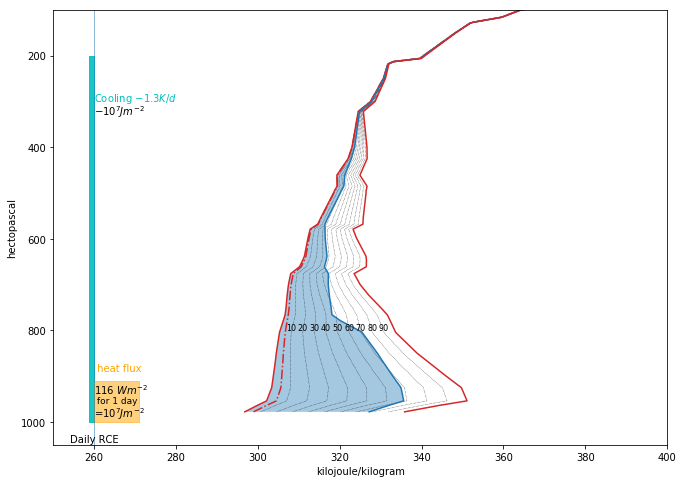

In [9]:
mep = massEnergyPlot()
mep.isohumes()

# Plot the sounding data
mep.ax.plot(s, pressure, color='tab:red', linewidth=1.5)
mep.ax.plot(sv, pressure, color='tab:red', linestyle='-.')
mep.ax.plot(h, pressure, color='tab:blue', linewidth=1.5)
mep.ax.plot(hs, pressure, color='tab:red', linewidth=1.5)
mep.shade_precipitable_water(pressure, s, h)
mep.rce_reference()
mep.radiative_cooling_reference()
mep.surface_flux_reference()
#mep.internal_waves(pressure)